In [1]:
import groio, rdkit
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
import os
# sys.path.append('/home/kopanichuk/data/autopsist/utils')
from src.utils_py.io.gro import read_gro, write_gro
from src.utils_py.gro.Structure import Structure
from src.utils_py.gro.Atom import Atom
from src.utils_py.geom.Box import Box
from src.utils_py.geom.AntiSphere import AntiSphere
from src.utils_py.geom.Sphere import Sphere
from src.utils_py.geom.Cylinder import Cylinder
from src.utils_py.geom.AntiCylinder import AntiCylinder
from src.utils_py.geom.CylinderSegment import CylinderSegment
from src.utils_py.geom.AntiCylinderSegment import AntiCylinderSegment
from src.utils_py.assembler.insert import insert_point_into_shape, find_position
from src.utils_py.assembler.push import push_atoms_apart
from src.utils_py.assembler.build import build_system

In [2]:
dir_gro = 'ff/gromos/gro/'

In [3]:
''' ПАРАМЕТРЫ НЕ ТРОГАТЬ!!! '''

insertion_limit = int(1e5)
rotation_limit = 10
package = 0.4
distance = {'min': 0.08**2, 'opt': 0.12**2}

In [5]:
system_size = np.full(3, 3.0) # nm
structure = Structure(box=system_size, atoms=[])
names = ['decane', 'spce']
density = dict(zip(names, [28/10, 33])) # nm-3
shapes = dict(zip(names, [
    Sphere(center=structure.get_center(), radius=1.0), 
    AntiSphere(center=structure.get_center(), radius=1.0, borders=structure.box)
]))
numbers = dict(zip(names, np.round([shapes[name].get_volume()*density[name] for name in names]).astype(int)))
print(numbers)
points = []
for name in names:
# for name in ['decane']:
    mol = read_gro(f'{dir_gro}{name}.gro').center_atoms_to_zero()
    mol_size = np.max(np.linalg.norm(mol.get_XYZ(), axis=1))
    for mol_idx in tqdm(range(numbers[name])):
        new_point = insert_point_into_shape(system_size, points, shapes[name], mol_size, mol_idx, insertion_limit, package)
        points.append(new_point)

        new_mol = find_position(structure, new_point, mol, mol_idx, rotation_limit, distance['min'])
        for atom in new_mol.atoms:
            new_atom = atom.copy()
            new_atom.idx = len(structure.atoms) + 1
            new_atom.mol_idx = mol_idx
            structure.atoms.append(new_atom)

{'decane': 12, 'spce': 753}


100%|██████████| 753/753 [00:03<00:00, 209.92it/s] 


In [6]:
structure = push_atoms_apart(structure, distance['min'], distance['opt'])

Iteration 1


Atoms: 100%|██████████| 2378/2378 [01:06<00:00, 35.59it/s] 

1 overlaps detected


In [19]:
structure

Structure(title='SYSTEM', box=array([3., 3., 3.]), atoms=[Atom(mol_idx=2, mol_name='DECAN', name='C1', idx=1, xyz=array([1.00444661, 2.03471568, 0.40631835])), Atom(mol_idx=2, mol_name='DECAN', name='C2', idx=2, xyz=array([1.14428077, 2.0580564 , 0.46517085])), Atom(mol_idx=2, mol_name='DECAN', name='C3', idx=3, xyz=array([1.14803156, 2.00522719, 0.60821632])), Atom(mol_idx=2, mol_name='DECAN', name='C4', idx=4, xyz=array([1.36799963, 2.01518219, 0.70749722])), Atom(mol_idx=2, mol_name='DECAN', name='C5', idx=5, xyz=array([1.30874206, 1.94660713, 0.79647366])), Atom(mol_idx=2, mol_name='DECAN', name='C6', idx=6, xyz=array([1.25162744, 1.80654771, 0.82037513])), Atom(mol_idx=2, mol_name='DECAN', name='C7', idx=7, xyz=array([1.2210867 , 1.76740614, 0.96473994])), Atom(mol_idx=2, mol_name='DECAN', name='C8', idx=8, xyz=array([1.13903742, 1.86939345, 1.04390119])), Atom(mol_idx=2, mol_name='DECAN', name='C9', idx=9, xyz=array([1.03412635, 1.80460881, 1.13499794])), Atom(mol_idx=2, mol_name

In [20]:
with open(f'decane_water_test.gro', 'w') as f:
    f.write(write_gro(structure))

---

# Speed up

In [78]:
system_size = np.full(3, 3.0) # nm
structure = Structure(box=system_size, atoms=[])
names = ['decane', 'spce']
density = dict(zip(names, [28/10, 33])) # nm-3
shapes = dict(zip(names, [
    Sphere(center=structure.get_center(), radius=1.0), 
    AntiSphere(center=structure.get_center(), radius=1.0, borders=structure.box)
]))
numbers = dict(zip(names, np.round([shapes[name].get_volume()*density[name] for name in names]).astype(int)))
print(numbers)

grid_size = np.array(np.ceil(system_size / distance['min']), dtype=np.int64)
print(grid_size)
grid = np.full(grid_size, -1)
grid_step = system_size / grid_size
# for name in names:
for name in ['decane']:
    mol = read_gro(f'{dir_gro}{name}.gro').center_atoms_to_zero()
    mol_size = np.max(np.linalg.norm(mol.get_XYZ(), axis=1))
    # for mol_idx in tqdm(range(numbers[name])):
    for mol_idx in tqdm(range(3)):
        new_mol = insert_mol_into_shape(mol, shapes[name])
        cell_id = (new_mol.get_XYZ() + system_size / 2) // grid_step
        # print(cell_id)
        for atom in new_mol.atoms:
            new_atom = atom.copy()
            new_atom.idx = len(structure.atoms) + 1
            new_atom.mol_idx = mol_idx + 1
            structure.atoms.append(new_atom)

{'decane': 12, 'spce': 753}
[469 469 469]


  0%|          | 0/3 [00:00<?, ?it/s]

[ 1.56771198 -2.71427571 -2.88051647]
[ 1.29379996 -2.81167189 -2.74423779]
[ 1.26186496 -2.19864571 -2.13428707]
[ 1.4046341  -2.69974801 -2.9711539 ]
[ 1.53385704 -2.80194501 -2.33226504]
[ 1.70428527 -2.60349228 -2.90355416]
[ 1.37324604 -2.66937536 -2.55747324]
[ 1.59179329 -2.7039415  -2.84762515]
[ 1.42499148 -2.80193017 -2.84760992]
[ 1.50403647 -2.88030096 -2.92990275]
[ 1.63421279 -2.92621332 -2.69590685]
[ 1.47174535 -2.08478671 -2.56163122]
[ 2.14978297 -3.25378568 -3.37315644]
[ 1.2016109  -3.04385467 -2.44267492]
[ 2.00250418 -2.92207291 -2.71150717]
[ 1.5185744  -2.80562854 -3.7507492 ]
[ 1.51015607 -3.41101548 -3.25539408]
[ 1.55001329 -2.77839205 -2.94268578]
[ 1.35242876 -2.57581974 -3.02547963]
[ 1.67071169 -2.21738163 -3.07526521]
[ 1.56359426 -2.74953263 -2.87390409]
[ 1.45992883 -2.21876253 -2.67193417]
[ 1.69820767 -2.64132586 -2.96086952]
[ 1.1561121  -3.44257585 -3.00876625]
[ 1.33982425 -2.73595102 -2.6803989 ]
[ 1.77390304 -2.83146263 -2.81324872]
[ 1.60240088

  0%|          | 0/3 [00:10<?, ?it/s]

[ 2.01302092 -2.90723563 -3.63100759]
[ 1.10744535 -3.08281751 -2.84157684]
[ 1.30324105 -3.08923448 -3.19561888]
[ 2.31731553 -2.36372108 -2.41578   ]
[ 1.16995276 -2.9595211  -2.78907798]
[ 1.63586533 -2.74222084 -3.05233425]
[ 1.9923957  -2.93360546 -2.84612048]
[ 1.71789962 -2.5106294  -3.07321448]
[ 1.54979937 -2.28684834 -2.4470638 ]
[ 1.48140071 -2.64485235 -2.85732554]
[ 1.46578392 -2.63893582 -2.3568548 ]
[ 1.78132142 -2.13078105 -3.30204375]
[ 1.4064764  -3.10183357 -2.86279479]
[ 1.2887878  -2.7729727  -2.93714762]
[ 1.88337639 -2.24236805 -2.51063053]
[ 1.67188439 -2.69448672 -2.5141925 ]
[ 2.21493383 -2.2355333  -2.50621543]
[ 1.27313612 -2.93938316 -2.61289293]
[ 1.58298468 -2.77502364 -2.84198986]
[ 1.28114153 -2.57967052 -2.99107643]
[ 1.48358092 -2.42448447 -3.26847224]
[ 1.63582694 -2.39471112 -2.44114145]
[ 1.48208934 -2.34625538 -3.01853301]
[ 1.49751428 -2.74341532 -2.93553552]
[ 1.85534167 -2.16202715 -3.07337103]
[ 1.70997413 -3.09675421 -3.25412528]
[ 1.69434541

KeyboardInterrupt: 

In [36]:
with open(f'decane_test.gro', 'w') as f:
    f.write(write_gro(structure))

In [23]:
np.ceil(system_size / distance['min'])

array([469., 469., 469.])

In [54]:
[1, 2, 3, 4, 5][1:]

[2, 3, 4, 5]

In [60]:
mol = read_gro(f'{dir_gro}decane.gro').center_atoms_to_zero()

In [61]:
mol.get_XYZ()

array([[ 0.38048108, -0.2301363 , -0.05787385],
       [ 0.23648108, -0.2811363 , -0.07287385],
       [ 0.13948108, -0.1681363 , -0.03987385],
       [-0.00151892, -0.2111363 , -0.08287385],
       [-0.10551892, -0.1021363 , -0.05787385],
       [-0.07851892,  0.0338637 , -0.12287385],
       [-0.15051892,  0.1548637 , -0.06387385],
       [-0.14051892,  0.1688637 ,  0.08812615],
       [-0.12151892,  0.3138637 ,  0.13412615],
       [-0.13451892,  0.3318637 ,  0.28512615]])

In [62]:
mol_size = np.max(np.linalg.norm(mol.get_XYZ(), axis=1))

In [64]:
mol_size

0.45773986033978975

In [22]:
data = np.loadtxt('runs/decane_water_test/potential.xvg', comments=['@', '#'])

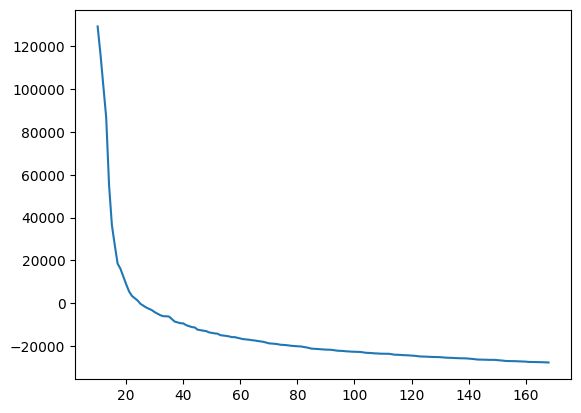

In [31]:
data = data[10:, :]
plt.plot(data[:, 0], data[:, 1])

---
# Test

In [80]:
dir_gro = 'ff/gromos/gro/'

''' ПАРАМЕТРЫ НЕ ТРОГАТЬ!!! '''
insertion_limit = int(1e5)
rotation_limit = 10
package = 0.3
distance = {'min': 0.08**2, 'opt': 0.12**2}

system_size = np.array([12, 4, 4]) # nm
structure_test = Structure(box=system_size, atoms=[])
# names = ['decane', 'water']
names = ['decane']
# density = dict(zip(names, [28 / 10, 33])) # nm-3
density = dict(zip(names, [28 / 10 - 1])) # nm-3
shapes = dict(zip(names, [
    # Cylinder(center=structure.get_center(), radius=1.0, length=3.0, axis=np.array([1, 0, 0])),
    # AntiCylinder(center=structure.get_center(), radius=1.0, length=3.0, axis=np.array([1, 0, 0]), borders_center=structure.get_center(), borders=structure.box)
    # CylinderSegment(
    #     center=np.array([1.5, 1.5, -0.4]), 
    #     cylinder=Cylinder(center=np.array([1.5, 1.5, -0.4]), 
    #         radius=1, 
    #         length=3, 
    #         axis=np.array([1, 0, 0])
    #     ),
    #     segm_radius=0.5,
    #     norm=np.array([0, 0, 1])
    # )
    Box(center=structure_test.get_center(), borders=structure_test.box)
]))

structure_test = build_system(
    dir_gro, structure_test, names, density, shapes,
    insertion_limit=insertion_limit,
    rotation_limit=rotation_limit,
    package=package,
    min_dist2=distance['min']
)

Number of molecules:
decane 	 346

Filling system:


  5%|▍         | 17/346 [00:05<01:40,  3.27it/s]


KeyboardInterrupt: 

In [78]:
with open(f'decane_test.gro', 'w') as f:
    f.write(write_gro(structure_test))

In [2]:
os.system('./mixer -f decane_test.gro -o decane_test_pbc.gro')

  12.000   4.000   4.000
Iteration 1 - 0s
24 overlaps detected
Iteration 2 - 0s
1 overlaps detected
Iteration 3 - 0s
0 overlaps detected


0

---
# Fixing 

In [29]:
structure = read_gro('solid/carbon/car_11.gro')

In [30]:
mol_id = 1
id = 1

for i, atom in enumerate(structure.atoms):
    # if (atom.mol_id > mol_id):
    #     atom.mol_id = mol_id
    #     mol_id += 1
    atom.mol_id = 1

    if (atom.id > id):
        atom.id = id
        id += 1

In [31]:
with open(f'car_fixed.gro', 'w') as f:
    f.write(write_gro(structure))

In [32]:
structure = read_gro('car_fixed.gro')

In [33]:
max(structure.atoms, key=lambda x: x.xyz[2] if x.xyz[2] < 3.5 else 0)

Atom(mol_id=1, mol_name='GRH', name='H', id=2, xyz=[1.1, 3.3, 1.167])

In [34]:
max_h = 1.167

In [35]:
for i, atom in enumerate(structure.atoms):
    atom.xyz[2] += 1.17

structure = structure.apply_pbc()

In [36]:
with open(f'car_shifted.gro', 'w') as f:
    f.write(write_gro(structure))

In [37]:
max(structure.atoms, key=lambda x: x.xyz[2])

Atom(mol_id=1, mol_name='GRH', name='H', id=2, xyz=array([1.1  , 3.3  , 2.337]))

In [2]:
dir_gro = 'ff/opls/gro/'

''' ПАРАМЕТРЫ НЕ ТРОГАТЬ!!! '''
insertion_limit = int(1e5)
rotation_limit = 10
package = 0.4
distance = {'min': 0.08**2, 'opt': 0.12**2}

system_size = np.full(3, 3.0) # nm
structure = Structure(box=system_size, atoms=[])
# names = ['decane', 'water']
names = ['water']
# density = dict(zip(names, [28 / 10, 33])) # nm-3
density = dict(zip(names, [33])) # nm-3

cylinder_segment = CylinderSegment(
    center=np.array([1.5, 1.5, 0]), 
    cylinder=Cylinder(center=np.array([1.5, 1.5, 0]), 
        radius=1, 
        length=3, 
        axis=np.array([1, 0, 0])
    ),
    segm_radius=0.5,
    norm=np.array([0, 0, 1])
)

box = Box(
    center=structure.get_center(),
    borders=system_size
)

shapes = dict(zip(names, [
    AntiCylinderSegment(center=np.array([1.5, 1.5, 0]), cylinder_segment=cylinder_segment, box=box)
]))

structure = build_system(dir_gro, structure, names, density, shapes)

Number of molecules:
water 	 830

Filling system:


100%|██████████| 830/830 [00:03<00:00, 207.53it/s] 



Pushing atoms apart:
Iteration 1


Atoms: 100%|██████████| 2489/2489 [00:24<00:00, 100.27it/s]


1 overlaps detected
Iteration 2


Atoms: 100%|██████████| 2489/2489 [00:24<00:00, 99.94it/s] 

0 overlaps detected


In [3]:
with open(f'water_anticylindersegment.gro', 'w') as f:
    f.write(write_gro(structure))

---
# Gromos droplet on silica

In [2]:
HEIGHT = 6
WIDTH = 5.6

offset = 1
delta_h = 0.3
h = 2.3

In [3]:
dir_gro = 'ff/gromos/gro/'

''' ПАРАМЕТРЫ НЕ ТРОГАТЬ!!! '''
insertion_limit = int(1e5)
rotation_limit = 10
package = 0.4
distance = {'min': 0.08**2, 'opt': 0.12**2}

system_size = np.array([WIDTH, WIDTH, HEIGHT + h])
# structure = Structure(box=system_size, atoms=[])
structure = read_gro('sil_shifted.gro')
points = list(structure.get_XYZ())
structure.box = system_size

names = ['decane', 'spce']
density = dict(zip(names, [28/10 - 0.05, 33 - 0.5])) # nm-3

box = Box(
    center=np.array([WIDTH/2, WIDTH/2, h + HEIGHT/2]),
    borders=np.array([WIDTH, WIDTH, HEIGHT - delta_h])
)

R = (WIDTH - 2 * offset) / np.sqrt(2)
r = (WIDTH - 2 * offset) / 2

cylinder_segment = CylinderSegment(
    center=np.array([WIDTH / 2, WIDTH / 2, h - r]), 
    cylinder=Cylinder(
        np.array([WIDTH / 2, WIDTH / 2, h - r]), 
        radius=R, 
        length=WIDTH, 
        axis=np.array([1, 0, 0])
    ),
    segm_radius=r,
    norm=np.array([0, 0, 1])
)

anticylinder_segment = AntiCylinderSegment(
    center=cylinder_segment.center,
    cylinder_segment=cylinder_segment,
    box=box
)

shapes = dict(zip(names, [anticylinder_segment, cylinder_segment]))

structure = build_system(
    dir_gro, structure, names, density, shapes, points,
    insertion_limit=insertion_limit,
    rotation_limit=rotation_limit,
    package=package
)

Number of molecules:
decane 	 463
spce 	 337

Filling system:


100%|██████████| 337/337 [00:19<00:00, 17.59it/s]


In [4]:
with open(f'na_diff/droplet_silica_gromos/gromos_raw_droplet.gro', 'w') as f:
    f.write(write_gro(structure))

In [5]:
os.system('./mixer -f na_diff/droplet_silica_gromos/gromos_raw_droplet.gro -o na_diff/droplet_silica_gromos/gromos_droplet.gro')

Iteration 1 - 3s
55 overlaps detected
Iteration 2 - 6s
5 overlaps detected
Iteration 3 - 9s
1 overlaps detected
Iteration 4 - 12s
0 overlaps detected


0

---
# Gromos droplet on carbon

In [44]:
os.system('cp ff/gromos/gro/decane.gro na_diff/droplet_carbon_gromos/decane.gro')
os.system('cp ff/gromos/itp/decane.itp na_diff/droplet_carbon_gromos/decane.itp')

os.system('cp ff/gromos/gro/spce.gro na_diff/droplet_carbon_gromos/spce.gro')
os.system('cp ff/gromos/itp/spce.itp na_diff/droplet_carbon_gromos/spce.itp')

os.system('cp ff/gromos/mdp/nvt_car_steep.mdp na_diff/droplet_carbon_gromos/nvt_car_steep.mdp')
os.system('cp ff/gromos/mdp/nvt_car_short.mdp na_diff/droplet_carbon_gromos/nvt_car_short.mdp')
os.system('cp ff/gromos/mdp/nvt_car.mdp na_diff/droplet_carbon_gromos/nvt_car.mdp')

os.system('cp ff/gromos/gromos.top na_diff/droplet_carbon_gromos/gromos.top')
os.system('cp ff/gromos/system.itp na_diff/droplet_carbon_gromos/system.itp')

os.system('cp solid/carbon/carbon.itp na_diff/droplet_carbon_gromos/carbon.itp')
os.system('cp solid/carbon/carmol_11.itp na_diff/droplet_carbon_gromos/carmol_11.itp')

0

In [38]:
HEIGHT = 6
WIDTH = 5.6

offset = 1
delta_h = 0.3
h = 2.3

In [39]:
dir_gro = 'ff/gromos/gro/'

''' ПАРАМЕТРЫ НЕ ТРОГАТЬ!!! '''
insertion_limit = int(1e5)
rotation_limit = 10
package = 0.4
distance = {'min': 0.08**2, 'opt': 0.12**2}

system_size = np.array([WIDTH, WIDTH, HEIGHT + h])
# structure = Structure(box=system_size, atoms=[])
structure = read_gro('car_shifted.gro')
points = list(structure.get_XYZ())
structure.box = system_size

names = ['decane', 'spce']
density = dict(zip(names, [28/10 - 0.05, 33 - 0.5])) # nm-3

box = Box(
    center=np.array([WIDTH/2, WIDTH/2, h + HEIGHT/2]),
    borders=np.array([WIDTH, WIDTH, HEIGHT - delta_h])
)

R = (WIDTH - 2 * offset) / np.sqrt(2)
r = (WIDTH - 2 * offset) / 2

cylinder_segment = CylinderSegment(
    center=np.array([WIDTH / 2, WIDTH / 2, h - r]), 
    cylinder=Cylinder(
        np.array([WIDTH / 2, WIDTH / 2, h - r]), 
        radius=R, 
        length=WIDTH, 
        axis=np.array([1, 0, 0])
    ),
    segm_radius=r,
    norm=np.array([0, 0, 1])
)

anticylinder_segment = AntiCylinderSegment(
    center=cylinder_segment.center,
    cylinder_segment=cylinder_segment,
    box=box
)

shapes = dict(zip(names, [anticylinder_segment, cylinder_segment]))

structure = build_system(
    dir_gro, structure, names, density, shapes, points,
    insertion_limit=insertion_limit,
    rotation_limit=rotation_limit,
    package=package
)

Number of molecules:
decane 	 463
spce 	 337

Filling system:


100%|██████████| 337/337 [00:12<00:00, 26.20it/s]


In [40]:
with open(f'na_diff/droplet_carbon_gromos/gromos_raw_droplet.gro', 'w') as f:
    f.write(write_gro(structure))

In [41]:
os.system('./mixer -f na_diff/droplet_carbon_gromos/gromos_raw_droplet.gro -o na_diff/droplet_carbon_gromos/gromos_droplet.gro')

Iteration 1 - 3s
53 overlaps detected
Iteration 2 - 6s
3 overlaps detected
Iteration 3 - 9s
0 overlaps detected


0

---
# OPLS droplet on silica

In [9]:
HEIGHT = 6
WIDTH = 5.6

offset = 1
delta_h = 0.3
h = 2.3

In [10]:
dir_gro = 'ff/opls/gro/'

''' ПАРАМЕТРЫ НЕ ТРОГАТЬ!!! '''
insertion_limit = int(1e5)
rotation_limit = 100
package = 0.35
distance = {'min': 0.06**2, 'opt': 0.1**2}

system_size = np.array([WIDTH, WIDTH, HEIGHT + h])
# structure = Structure(box=system_size, atoms=[])
structure = read_gro('sil_shifted.gro')
points = list(structure.get_XYZ())
structure.box = system_size

names = ['decane', 'tip4p']
density = dict(zip(names, [28/10 - 0.05, 33 - 0.5])) # nm-3

box = Box(
    center=np.array([WIDTH/2, WIDTH/2, h + HEIGHT/2]),
    borders=np.array([WIDTH, WIDTH, HEIGHT - delta_h])
)

R = (WIDTH - 2 * offset) / np.sqrt(2)
r = (WIDTH - 2 * offset) / 2

cylinder_segment = CylinderSegment(
    center=np.array([WIDTH / 2, WIDTH / 2, h - r]), 
    cylinder=Cylinder(
        np.array([WIDTH / 2, WIDTH / 2, h - r]), 
        radius=R, 
        length=WIDTH, 
        axis=np.array([1, 0, 0])
    ),
    segm_radius=r,
    norm=np.array([0, 0, 1])
)

anticylinder_segment = AntiCylinderSegment(
    center=cylinder_segment.center,
    cylinder_segment=cylinder_segment,
    box=box
)

shapes = dict(zip(names, [anticylinder_segment, cylinder_segment]))

structure = build_system(
    dir_gro, structure, names, density, shapes, points,
    insertion_limit=insertion_limit,
    rotation_limit=rotation_limit,
    package=package,
    min_dist2=distance['min']
)

Number of molecules:
decane 	 463
tip4p 	 337

Filling system:


100%|██████████| 337/337 [00:09<00:00, 35.94it/s]


In [11]:
with open(f'na_diff/droplet_silica_opls/opls_raw_droplet.gro', 'w') as f:
    f.write(write_gro(structure))

In [13]:
os.system(f'./mixer -f na_diff/droplet_silica_opls/opls_raw_droplet.gro -o na_diff/droplet_silica_opls/opls_droplet.gro -mn2 {distance["min"]} -opt2 {distance["opt"]}')

Iteration 1 - 13s
253 overlaps detected
Iteration 2 - 26s
19 overlaps detected
Iteration 3 - 38s
2 overlaps detected
Iteration 4 - 51s
0 overlaps detected


0

---
# Test of H removing

In [7]:
os.system('./mixer -f ff/opls/gro/decane.gro -o decane_push_test.gro')

Iteration 1 - 0s
0 overlaps detected


0

---
# Droplet on calcit

In [18]:
folder = 'droplet_calcit_gromos'

In [17]:
os.system(f'cp ff/gromos/gro/decane.gro na_diff/{folder}/decane.gro')
os.system(f'cp ff/gromos/itp/decane.itp na_diff/{folder}/decane.itp')

os.system(f'cp ff/gromos/gro/spce.gro na_diff/{folder}/spce.gro')
os.system(f'cp ff/gromos/itp/spce.itp na_diff/{folder}/spce.itp')

os.system(f'cp ff/gromos/mdp/nvt_car_steep.mdp na_diff/{folder}/nvt_car_steep.mdp')
os.system(f'cp ff/gromos/mdp/nvt_car_short.mdp na_diff/{folder}/nvt_car_short.mdp')
os.system(f'cp ff/gromos/mdp/nvt_car.mdp na_diff/{folder}/nvt_car.mdp')

os.system(f'cp ff/gromos/gromos.top na_diff/{folder}/gromos.top')
os.system(f'cp ff/gromos/system.itp na_diff/{folder}/system.itp')

os.system(f'cp solid/cal.gro na_diff/{folder}/cal.gro')
os.system(f'cp solid/carbon/carbon.itp na_diff/{folder}/carbon.itp')
os.system(f'cp solid/carbon/carmol_11.itp na_diff/{folder}/carmol_11.itp')

0

In [17]:
structure = read_gro(f'na_diff/{folder}/cal_fixed.gro')

In [20]:
structure.atoms

[Atom(mol_id=1, mol_name='Oh', name='O', id=1, xyz=[0.062, 11.244, 0.243]),
 Atom(mol_id=1, mol_name='Oh', name='O', id=2, xyz=[0.0, 10.399, 0.081]),
 Atom(mol_id=1, mol_name='Oh', name='O', id=3, xyz=[0.0, 10.949, 0.405]),
 Atom(mol_id=1, mol_name='Oh', name='O', id=4, xyz=[0.062, 2.136, 0.027]),
 Atom(mol_id=1, mol_name='Oh', name='O', id=5, xyz=[0.0, 2.116, 0.351]),
 Atom(mol_id=1, mol_name='Oh', name='O', id=6, xyz=[0.125, 3.846, 0.027]),
 Atom(mol_id=1, mol_name='Oh', name='O', id=7, xyz=[0.187, 5.557, 0.027]),
 Atom(mol_id=1, mol_name='Oh', name='O', id=8, xyz=[1.248, 7.267, 0.027]),
 Atom(mol_id=1, mol_name='Oh', name='O', id=9, xyz=[1.373, 10.688, 0.027]),
 Atom(mol_id=1, mol_name='Oh', name='O', id=10, xyz=[1.747, 7.267, 0.027]),
 Atom(mol_id=1, mol_name='Oh', name='O', id=11, xyz=[2.87, 10.688, 0.027]),
 Atom(mol_id=1, mol_name='Oh', name='O', id=12, xyz=[3.245, 7.267, 0.027]),
 Atom(mol_id=1, mol_name='Oh', name='O', id=13, xyz=[3.557, 2.136, 0.027]),
 Atom(mol_id=1, mol_nam

In [21]:
names = dict(zip(set(a.mol_name for a in structure.atoms), [0, 0, 0, 0]))

for a in structure.atoms:
    names[a.mol_name] += 1

for key, item in names.items():
    print(str(key)+':', '\t', item)

Caa: 	 6122
OCaa: 	 18431
CCaa: 	 6177
Oh: 	 128


In [24]:
names = dict(zip(set(a.name for a in structure.atoms), [0 for i in range(len(set(a.name for a in structure.atoms)))]))

for a in structure.atoms:
    names[a.name] += 1

for key, item in names.items():
    print(str(key), '\t', item)

C5 	 2017
C1 	 2017
OW 	 1311
Ca 	 6122
HW2 	 1311
C2 	 2017
C7 	 2017
C3 	 2017
C8 	 2017
C6 	 2017
HW1 	 1311
CCa 	 6177
C4 	 2017
C10 	 2017
C9 	 2017
O 	 18559


In [34]:
new_structe = structure.copy()
new_structe.atoms = []

id = 1
for key in names:
    for a in structure.atoms:
        if (a.name == key):
            new_structe.atoms.append(a.copy())
            if (a.name == 'O'):
                new_structe.atoms[-1].mol_name = 'Oh'
                new_structe.atoms[-1].mol_id = id
            elif (a.name == 'CA'):
                new_structe.atoms[-1].name = 'Ca'
                new_structe.atoms[-1].mol_name = 'Caa'
                new_structe.atoms[-1].mol_id = id
            elif (a.name == 'OCA'):
                new_structe.atoms[-1].name = 'OCa'
                new_structe.atoms[-1].mol_name = 'OCaa'
                new_structe.atoms[-1].mol_id = id
            elif (a.name == 'CCA'):
                new_structe.atoms[-1].name = 'CCa'
                new_structe.atoms[-1].mol_name = 'CCaa'
                new_structe.atoms[-1].mol_id = id
    id += 1

In [20]:
for a in structure.atoms:
    if (a.name == 'O'):
        a.name = 'Oo'

In [42]:
mol_names = dict(zip(set(a.mol_name for a in new_structe.atoms), [0, 0, 0, 0]))

for a in new_structe.atoms:
    mol_names[a.mol_name] += 1

for key, item in mol_names.items():
    print(str(key), '\t', item)

Oh 	 128
Caa 	 6122
CCaa 	 6177
OCaa 	 18431


In [37]:
id = 1
for i, a in enumerate(new_structe.atoms):
    a.id = i + 1

In [22]:
with open(f'na_diff/droplet_calcit_gromos/cal_fixed.gro', 'w') as f:
    f.write(write_gro(new_structe))

In [2]:
# 9.23520  13.49130   3.02020
HEIGHT = 6.5
WIDTH_X = 9.23520
WIDTH_Y = 13.49130

offset = 4
delta_h = 0.3
h = 3.02020

In [3]:
folder = 'droplet_calcit_gromos'
dir_gro = 'ff/gromos/gro/'

''' ПАРАМЕТРЫ НЕ ТРОГАТЬ!!! '''
insertion_limit = int(1e5)
rotation_limit = 1000
package = 0.35
distance = {'min': 0.08**2, 'opt': 0.12**2}

system_size = np.array([WIDTH_X, WIDTH_Y, HEIGHT + h])
# structure = Structure(box=system_size, atoms=[])
structure = read_gro(f'na_diff/{folder}/cal_fixed.gro')
points = list(structure.get_XYZ())
structure.box = system_size

names = ['spce', 'decane']
density = dict(zip(names, [33, 3])) # nm-3
# names = ['spce']
# density = dict(zip(names, [33])) # nm-3

box = Box(
    center=np.array([WIDTH_X/2, WIDTH_Y/2, h + HEIGHT/2]),
    borders=np.array([WIDTH_X, WIDTH_Y, HEIGHT - 2 * delta_h])
)

R = (WIDTH_Y - 2 * offset) / np.sqrt(2)
r = (WIDTH_Y - 2 * offset) / 2

cylinder_segment = CylinderSegment(
    center=np.array([WIDTH_X/2, WIDTH_Y/2, h - r]), 
    cylinder=Cylinder(
        np.array([WIDTH_X/2, WIDTH_Y/2, h - r]), 
        radius=R, 
        length=WIDTH_X, 
        axis=np.array([1, 0, 0])
    ),
    segm_radius=r,
    norm=np.array([0, 0, 1])
)

anticylinder_segment = AntiCylinderSegment(
    center=cylinder_segment.center,
    cylinder_segment=cylinder_segment,
    box=box
)

shapes = dict(zip(names, [cylinder_segment, anticylinder_segment]))
# shapes = dict(zip(names, [cylinder_segment]))

structure = build_system(
    dir_gro, structure, names, density, shapes, points,
    insertion_limit=insertion_limit,
    rotation_limit=rotation_limit,
    package=package,
    min_dist2=distance['min']
)

Number of molecules:
spce 	 1311
decane 	 2086

Filling system:


100%|██████████| 2086/2086 [08:12<00:00,  4.24it/s]


In [4]:
with open(f'na_diff/{folder}/gromos_raw_droplet.gro', 'w') as f:
    f.write(write_gro(structure))

In [5]:
os.system(f'./mixer -f na_diff/{folder}/gromos_raw_droplet.gro -o na_diff/{folder}/gromos_droplet.gro -mn2 {distance["min"]} -opt2 {distance["opt"]}')

Iteration 1 - 84s
197 overlaps detected
Iteration 2 - 168s
6 overlaps detected
Iteration 3 - 253s
0 overlaps detected


0

---

In [56]:
with open(f'na_diff/{folder}/test_raw_droplet.gro', 'w') as f:
    f.write(write_gro(structure))

In [96]:
folder

'droplet_calcit_gromos'

In [34]:
# Ca - O
# eps = 0.0005 * 96.4
# sigma = 3.33 * 0.1

# O - O
eps = 0.0070576 * 96.4
sigma = 3.16435 * 0.1

# Ca
# eps = 2
# sigma = 2.37 * 0.1

# C
# eps = 0.369
# sigma = 3.82 * 0.1

# O
# eps = 0.582
# sigma = 3.09 * 0.1

# Ow
eps = 6.73853e-3
sigma = 3.16556 * 0.1

C6 = 4 * eps * sigma**6
C12 = 4 * eps * sigma**12
print('C6 :\t', C6)
print('C12:\t', C12)

C6 :	 2.7122421120125813e-05
C12:	 2.729177310991592e-08


In [14]:
structure = read_gro(f'na_diff/{folder}/gromos_droplet.gro')

In [18]:
for a in structure.atoms:
    if (a.name == 'O'):
        a.name = 'Oo'

In [16]:
with open(f'na_diff/{folder}/gromos_droplet.gro', 'w') as f:
    f.write(write_gro(structure))

In [10]:
os.system(f'./mixer -f na_diff/{folder}/gromos_droplet.gro -o na_diff/{folder}/gromos_droplet.gro -mn2 {distance["min"]} -opt2 {distance["opt"]}')

Iteration 1 - 90s
0 overlaps detected


0

In [125]:
# 116 113 109
Oh 	  =  128
Caa   =	 6122
OCaa  =  18431
CCaa  =	 6177

print(np.float32(-0.899*Oh + 1.669*Caa + -0.899*OCaa + 0.999*CCaa))

charge = round(np.float32(-(1.669*Caa + -0.899*OCaa + 0.999*CCaa) / Oh), 7)
print(charge)

print(np.float32(charge*Oh + 1.669*Caa + -0.899*OCaa + 0.999*CCaa))

-296.1
1.4142812
-1.2207056e-07


In [119]:
(0.000463 - (1.669*Caa + -0.899*OCaa + 0.999*CCaa)) / Oh

1.414284867187502

In [13]:
128 + 6122 + 18431 + 6177

30858

In [10]:
# 116 113 109
Oh 	  =  128
Caa   =	 6122
OCaa  =  18431
CCaa  =	 6177

print(np.float64(-0.899*Oh + 1.669*Caa + -0.899*OCaa + 0.999*CCaa))

charge = round(np.float64(-(1.669*Caa + -0.899*OCaa + 0.999*CCaa) / Oh), 7)
print(charge)

print(np.float64(charge*Oh + 1.669*Caa + -0.899*OCaa + 0.999*CCaa))

-296.10000000000036
1.4142813
6.399999620043673e-06


In [70]:
print(-0.899*Oh + 1.668*Caa + -0.899*OCaa + 0.999*CCaa)

-295.03000000000065

In [71]:
charge = -(1.668*Caa + -0.899*OCaa + 0.999*CCaa) / Oh

In [72]:
(charge*Oh + 1.668*Caa + -0.899*OCaa + 0.999*CCaa)

0.0

In [6]:
Oh 	  =  128

In [23]:
charge = 181.027537 / Oh
charge

1.4142776328125

In [11]:
(charge*Oh + 1.668*Caa + -0.899*OCaa + 0.999*CCaa)

-6.121993600001588

In [25]:
296.099536 / OCaa - 0.899

-0.8829347004503283

In [20]:
rho = 0.73 
M = 142.3
Na = 6.02e+23

rho / M * Na * (1e-7)**3

3.0882642304989454

In [21]:
rho = 1
M = 18
Na = 6.02e+23

rho / M * Na * (1e-7)**3

33.44444444444444